# Preprocesamiento de datos dipositivos IoT

**Autor:** Roberto Muñoz <br />
**Github:** <https://github.com/rpmunoz> <br />

Este notebook fomar parte del desarrollo de un proyecto de data science y machine learning ejecutado para un cliente que ofrece servicios en la industria agrícola. Los datos usadaos en este notebook fueron recolectados por una estación ubicada en un campo agrícola remoto, la cual permite realizar mediciones de nivel de humedad de suelo a diferentes profundidades.


Este notebook se apoya en múltiples librerías estándares de python y algunas otras de caracter privado desarrolladas por el equipo de desarrollo del proyecto. Las principales librerías estándares usadas son:
- numpy
- pandas
- scipy
- statsmodels
- matplotlib
- seaborn
- datetime
- pyyaml

In [1]:
# In order to use matplotlib widget, fol

%matplotlib inline
#%matplotlib widget

In [2]:
import os, sys, glob
import numpy as np
import pandas as pd
import datetime
import time
import yaml

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
sns.set()

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
# What station to analyze
stationId = 76

dataDir = 'data'
configDir = 'config'
modelDir = 'models'
resultsDir = 'results'

## Lectura de datos raw

In [33]:
dataFile = os.path.join(dataDir, 'IoT_station_raw.csv')
dataDF = pd.read_csv(dataFile)

dataDF.head()

,id,stationId,paramId,value,sequence,datetime
0,0,76,221,11869.00,41008,2019-01-01 00:08:20
1,1,76,231,31575.00,41008,2019-01-01 00:08:20
2,2,76,238,25781.00,41008,2019-01-01 00:08:20
3,3,76,247,-83.00,41008,2019-01-01 00:08:20
4,4,76,232,31560.00,41008,2019-01-01 00:08:20


In [34]:
dataDF.dtypes

id             int64
stationId      int64
paramId        int64
value        float64
sequence       int64
datetime      object
dtype: object

In [35]:
dataDF.describe()

,id,stationId,paramId,value,sequence
count,231919.00,231919.00,231919.00,231919.00,231919.00
mean,115959.00,76.00,261.15,17197.79,11334.94
std,66949.39,0.00,34.85,8363.26,11035.38
min,0.00,76.00,221.00,-113.00,2.00
25%,57979.50,76.00,234.00,12132.00,2956.50
50%,115959.00,76.00,247.00,18863.00,7697.00
75%,173938.50,76.00,304.00,23348.00,16307.00
max,231918.00,76.00,310.00,34444.00,50148.00


In [36]:
dataDF['paramId'].unique()

array([221, 231, 238, 247, 232, 234, 308, 301, 236, 304, 310, 306, 240,
       302], dtype=int64)

<AxesSubplot:xlabel='paramId', ylabel='value'>

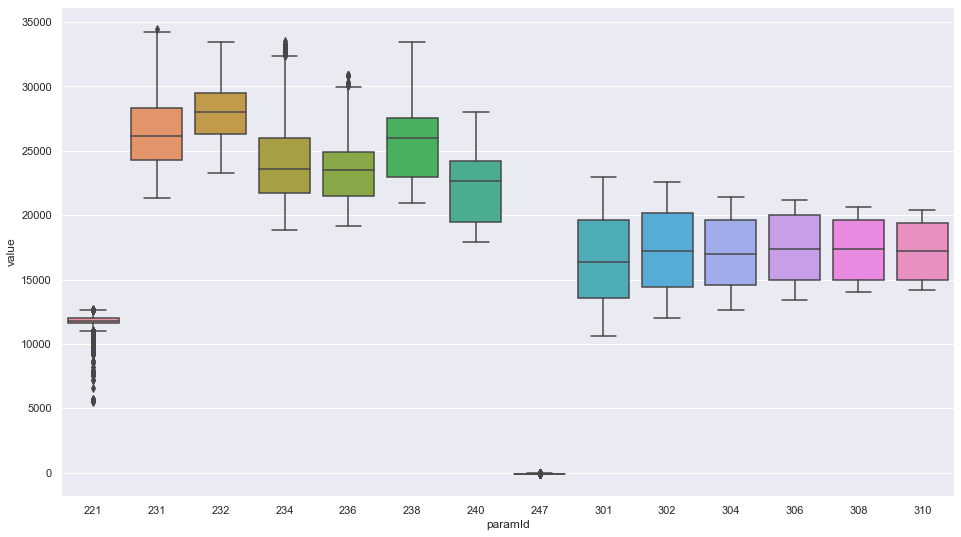

In [37]:
plt.figure(figsize=(16,9))
sns.boxplot(x='paramId', y='value', data=dataDF)

## Lectura de archivo de configuracion

In [103]:
def read_yaml(configFile, stationId=None):

    if isinstance(configFile, str):
        configFileList = list(configFile)
    elif isinstance(configFile, list):
        configFileList = configFile

    configDF = pd.DataFrame()
    paramsDF = pd.DataFrame()
    convertDF = pd.DataFrame()
    
    for configFile in configFileList:
        with open(configFile) as f:
            configData = yaml.full_load(f)

        stationId = configData[0]['stationId']
            
        for dct in configData[1]:
            for key, value in dct.items():
                if key == 'config':
                    tempDF = pd.DataFrame(value)
                    tempDF['stationId'] = stationId
                    configDF = configDF.append(tempDF, ignore_index=True, sort=False)
                elif key == 'params':
                    tempDF = pd.DataFrame(value)
                    tempDF['stationId'] = stationId
                    paramsDF = paramsDF.append(tempDF, ignore_index=True, sort=False)
                elif key == 'convert':
                    tempDF = pd.DataFrame(value)
                    tempDF['stationId'] = stationId
                    convertDF = convertDF.append(tempDF, ignore_index=True, sort=False)

    configDict = {'config':configDF, 'params':paramsDF, 'convert':convertDF}
    
    return configDict

In [104]:
configFileList = glob.glob(os.path.join(configDir, '*.yaml'))
configDict = read_yaml(configFileList)

configDF = configDict['config']
configParamsDF = configDict['params']

In [105]:
configParamsDF

,paramName,paramId,stationId
0,Humedad 10,231,76
1,Humedad 20,232,76
2,Humedad 30,233,76
3,Humedad 40,234,76
4,Humedad 50,235,76
5,Humedad 60,236,76
6,Humedad 70,237,76
7,Humedad 80,238,76
8,Humedad 100,240,76


## Preparacion de los datos

### Creacion de campos tipo datetime

In [41]:
dataDF['datetime'] = pd.to_datetime(dataDF['datetime'], utc=False)
dataDF.head()

,id,stationId,paramId,value,sequence,datetime
0,0,76,221,11869.00,41008,2019-01-01 00:08:20
1,1,76,231,31575.00,41008,2019-01-01 00:08:20
2,2,76,238,25781.00,41008,2019-01-01 00:08:20
3,3,76,247,-83.00,41008,2019-01-01 00:08:20
4,4,76,232,31560.00,41008,2019-01-01 00:08:20


In [42]:
dataDF.dtypes

id                    int64
stationId             int64
paramId               int64
value               float64
sequence              int64
datetime     datetime64[ns]
dtype: object

### Mantener registros de interes

In [75]:
dataDF['paramId'].unique()

array([221, 231, 238, 247, 232, 234, 308, 301, 236, 304, 310, 306, 240,
       302], dtype=int64)

In [76]:
paramIdList = configParamsDF['paramId'].tolist()
print(paramIdList)

[231, 232, 233, 234, 235, 236, 237, 238, 240]


In [77]:
paramIdList.extend(['stationId', 'value', 'datetime', 'timestamp'])
print(paramIdList)

[231, 232, 233, 234, 235, 236, 237, 238, 240, 'stationId', 'value', 'datetime', 'timestamp']


In [78]:
dataDF = dataDF[ dataDF['paramId'].isin(paramIdList)]
dataDF['paramId'].unique()

array([231, 238, 232, 234, 236, 240], dtype=int64)

### Pivoteamos el dataframe para transformar algunos registros en campos

In [135]:
dataPivotDF = dataDF.pivot_table(index = 'datetime', columns = 'paramId', values = 'value')
dataPivotDF.rename_axis('', axis = 'columns', inplace=True)
dataPivotDF.head()

,231,232,234,236,238,240
datetime,,,,,,
2019-01-01 00:08:20,31575.00,31560.00,29541.00,nan,25781.00,nan
2019-01-01 00:18:56,nan,nan,nan,23824.00,nan,nan
2019-01-01 00:29:30,nan,nan,29464.00,nan,nan,nan
2019-01-01 00:40:32,nan,nan,29424.00,nan,25807.00,23646.00
2019-01-01 00:51:07,nan,31494.00,nan,23891.00,nan,23660.00


In [136]:
renameDict = configParamsDF[['paramId', 'paramName']].set_index('paramId').to_dict()['paramName']
renameDict

{231: 'Humedad 10',
 232: 'Humedad 20',
 233: 'Humedad 30',
 234: 'Humedad 40',
 235: 'Humedad 50',
 236: 'Humedad 60',
 237: 'Humedad 70',
 238: 'Humedad 80',
 240: 'Humedad 100'}

In [137]:
dataPivotDF.rename(columns=renameDict, inplace=True)
dataPivotDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100
datetime,,,,,,
2019-01-01 00:08:20,31575.00,31560.00,29541.00,nan,25781.00,nan
2019-01-01 00:18:56,nan,nan,nan,23824.00,nan,nan
2019-01-01 00:29:30,nan,nan,29464.00,nan,nan,nan
2019-01-01 00:40:32,nan,nan,29424.00,nan,25807.00,23646.00
2019-01-01 00:51:07,nan,31494.00,nan,23891.00,nan,23660.00


### Visualizamos la serie de tiempo

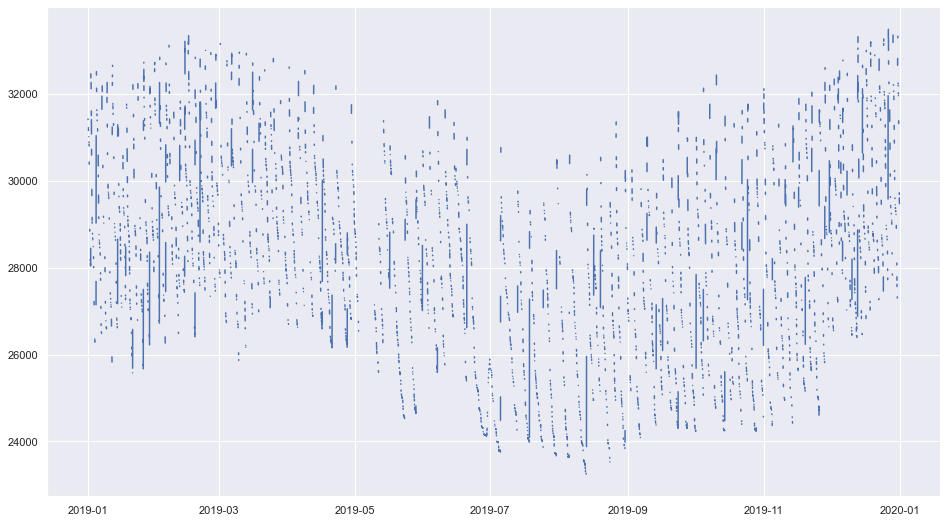

In [153]:
plt.figure(figsize=(16,9))
plt.plot(dataPivotDF['Humedad 20'])

(17897.0, 17985.0)

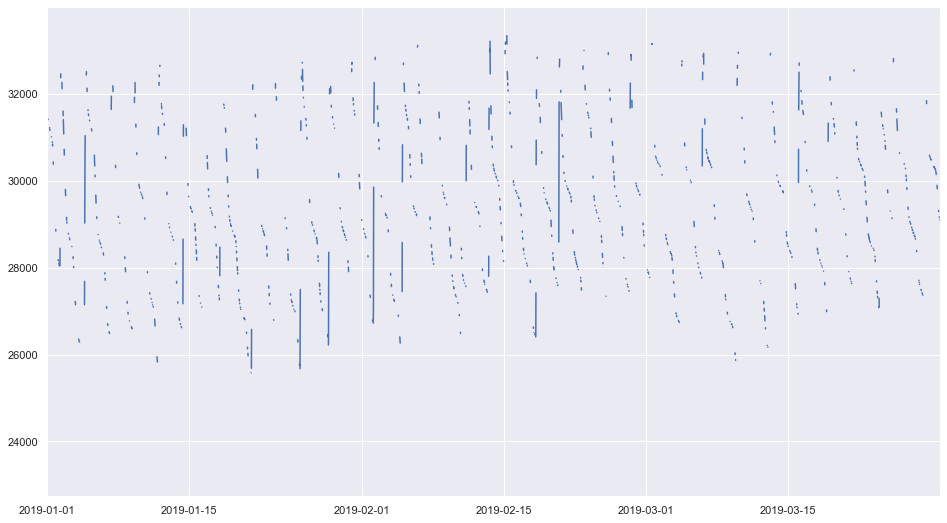

In [127]:
plt.figure(figsize=(16,9))
plt.plot(dataPivotDF['Humedad 20'])

plt.xlim(datetime.date(2019,1,1),datetime.date(2019,3,30))

(17897.0, 17985.0)

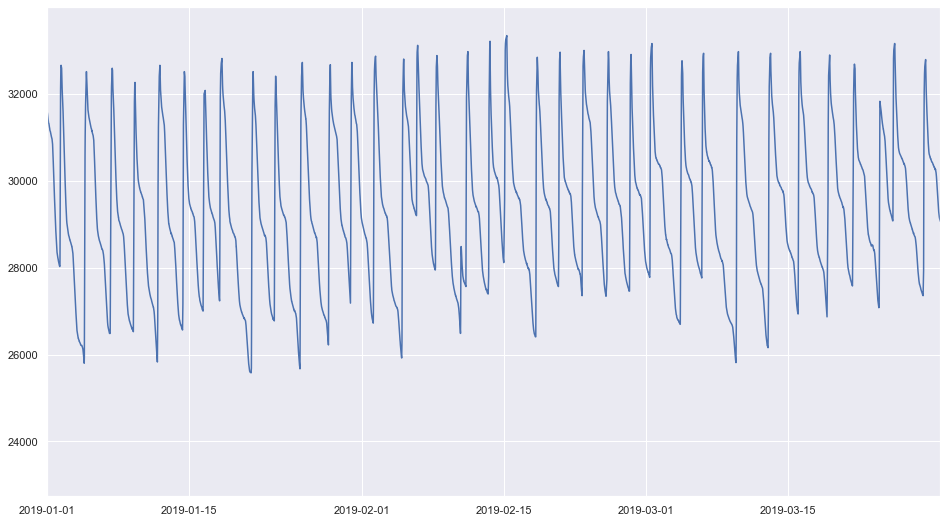

In [126]:
dataPlotDF = dataPivotDF['Humedad 20']
dataPlotDF = dataPlotDF.dropna(axis=0, how='any')

plt.figure(figsize=(16,9))
plt.plot(dataPlotDF)

plt.xlim(datetime.date(2019,1,1),datetime.date(2019,3,30))

### Imputamos los missing values

In [138]:
len(dataPivotDF)

42683

In [139]:
dataPivotDF.isnull().sum().sort_values(ascending = False)


Humedad 40     28200
Humedad 100    28199
Humedad 80     28199
Humedad 60     28199
Humedad 20     28199
Humedad 10     28199
dtype: int64

### Metodo 1

In [140]:
dataCleanDF = dataPivotDF.dropna(axis=0, how='any')
dataCleanDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100
datetime,,,,,,
2019-01-02 05:54:46,30446.00,28050.00,23126.00,22997.00,26456.00,23687.00
2019-01-25 11:33:51,25005.00,26946.00,22188.00,22970.00,26535.00,23687.00
2019-02-01 04:13:57,26822.00,28892.00,24208.00,24532.00,27358.00,23515.00
2019-02-03 11:17:34,27348.00,29155.00,25042.00,24853.00,28642.00,25144.00
2019-02-05 16:22:45,30001.00,30837.00,28133.00,25668.00,28735.00,24137.00


In [141]:
len(dataCleanDF)

39

### Metodo 2

In [142]:
dataCleanDF = dataPivotDF.copy()
dataCleanDF['Humedad total'] = dataCleanDF['Humedad 20'] + dataCleanDF['Humedad 40']
dataCleanDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100,Humedad total
datetime,,,,,,,
2019-01-01 00:08:20,31575.00,31560.00,29541.00,nan,25781.00,nan,61101.00
2019-01-01 00:18:56,nan,nan,nan,23824.00,nan,nan,nan
2019-01-01 00:29:30,nan,nan,29464.00,nan,nan,nan,nan
2019-01-01 00:40:32,nan,nan,29424.00,nan,25807.00,23646.00,nan
2019-01-01 00:51:07,nan,31494.00,nan,23891.00,nan,23660.00,nan


In [143]:
dataCleanDF.isnull().sum().sort_values(ascending = False)


Humedad total    38293
Humedad 40       28200
Humedad 100      28199
Humedad 80       28199
Humedad 60       28199
Humedad 20       28199
Humedad 10       28199
dtype: int64

In [145]:
dataCleanDF = dataCleanDF[['Humedad total']]
dataCleanDF.head()

,Humedad total
datetime,
2019-01-01 00:08:20,61101.00
2019-01-01 00:18:56,nan
2019-01-01 00:29:30,nan
2019-01-01 00:40:32,nan
2019-01-01 00:51:07,nan


In [146]:
dataCleanDF = dataCleanDF.dropna(axis=0, how='any')
dataCleanDF.head()

,Humedad total
datetime,
2019-01-01 00:08:20,61101.00
2019-01-01 03:41:01,60345.00
2019-01-01 04:23:18,60226.00
2019-01-01 07:14:57,59872.00
2019-01-01 09:33:47,59585.00


In [147]:
len(dataCleanDF)

4390

### Metodo 3

In [148]:
dataCleanDF = dataPivotDF.resample('30min').mean().interpolate('linear')
dataCleanDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100
datetime,,,,,,
2019-01-01 00:00:00,31575.00,31560.00,29502.50,23824.00,25781.00,nan
2019-01-01 00:30:00,31487.75,31494.00,29424.00,23891.00,25807.00,23653.00
2019-01-01 01:00:00,31400.50,31451.50,29343.83,23911.50,25833.00,23646.00
2019-01-01 01:30:00,31346.00,31409.00,29263.67,23954.00,25886.00,23653.00
2019-01-01 02:00:00,31272.00,31366.00,29183.50,23996.50,25939.00,23660.00


In [149]:
dataCleanDF.isnull().sum().sort_values(ascending = False)


Humedad 100    1
Humedad 80     0
Humedad 60     0
Humedad 40     0
Humedad 20     0
Humedad 10     0
dtype: int64

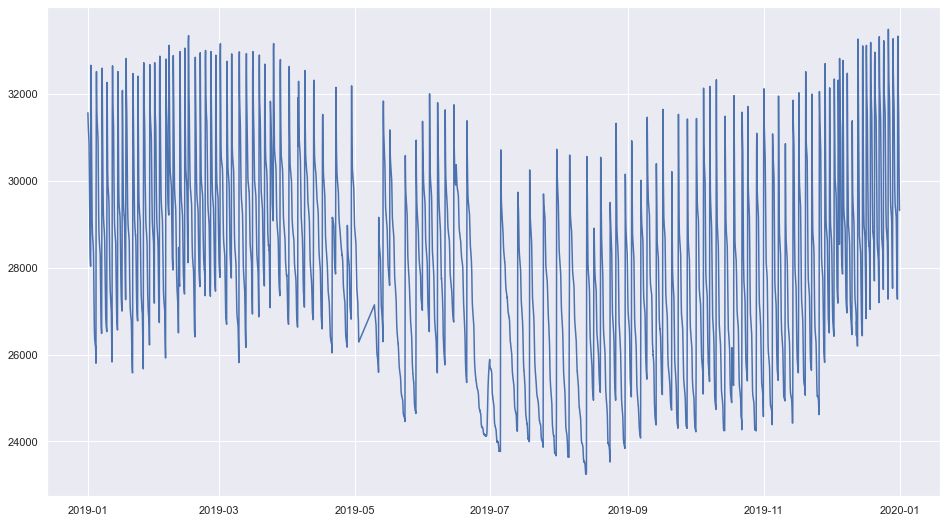

In [151]:
plt.figure(figsize=(16,9))
plt.plot(dataCleanDF['Humedad 20'])

(18017.0, 18046.0)

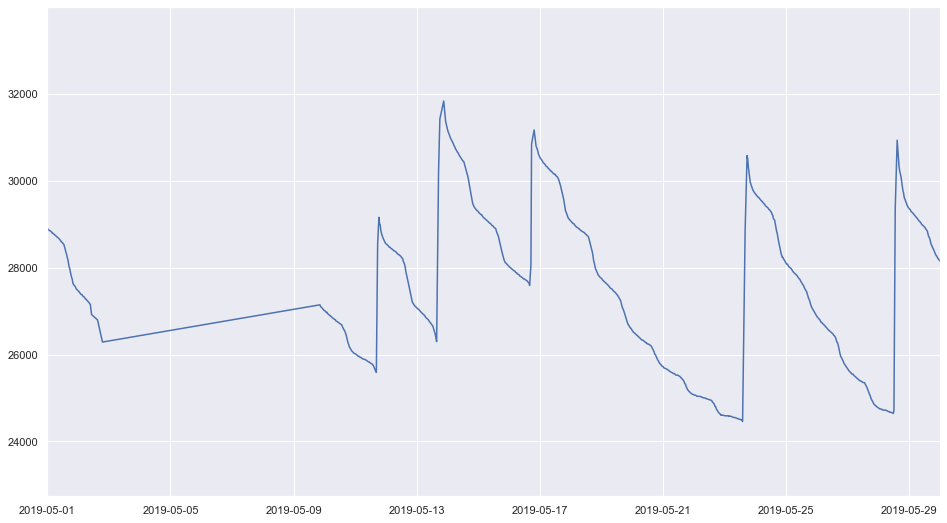

In [159]:
plt.figure(figsize=(16,9))
plt.plot(dataCleanDF['Humedad 20'])

plt.xlim(datetime.date(2019,5,1),datetime.date(2019,5,30))

### Metodo 4

In [173]:
dataCleanDF = dataPivotDF.resample('30min').mean().interpolate('linear', limit=10, limit_area='inside')
dataCleanDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100
datetime,,,,,,
2019-01-01 00:00:00,31575.00,31560.00,29502.50,23824.00,25781.00,nan
2019-01-01 00:30:00,31487.75,31494.00,29424.00,23891.00,25807.00,23653.00
2019-01-01 01:00:00,31400.50,31451.50,29343.83,23911.50,25833.00,23646.00
2019-01-01 01:30:00,31346.00,31409.00,29263.67,23954.00,25886.00,23653.00
2019-01-01 02:00:00,31272.00,31366.00,29183.50,23996.50,25939.00,23660.00


In [174]:
dataCleanDF.isnull().sum().sort_values(ascending = False)


Humedad 80     332
Humedad 60     332
Humedad 100    331
Humedad 40     331
Humedad 20     331
Humedad 10     331
dtype: int64

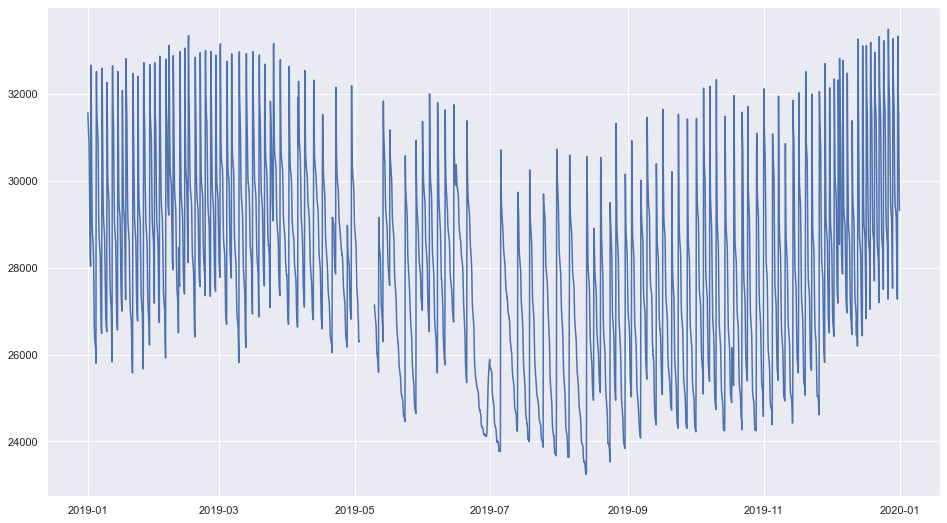

In [175]:
plt.figure(figsize=(16,9))
plt.plot(dataCleanDF['Humedad 20'])

In [181]:
dataCleanDF = dataCleanDF.dropna(axis=0, how='any')
dataCleanDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100,timestamp,cos_Day,sin_Day,cos_Year,sin_Year
datetime,,,,,,,,,,,
2019-01-01 00:30:00,31487.75,31494.00,29424.00,23891.00,25807.00,23653.00,1546302600,0.99,0.13,0.98,0.21
2019-01-01 01:00:00,31400.50,31451.50,29343.83,23911.50,25833.00,23646.00,1546304400,0.97,0.26,0.98,0.21
2019-01-01 01:30:00,31346.00,31409.00,29263.67,23954.00,25886.00,23653.00,1546306200,0.92,0.38,0.98,0.21
2019-01-01 02:00:00,31272.00,31366.00,29183.50,23996.50,25939.00,23660.00,1546308000,0.87,0.50,0.98,0.21
2019-01-01 02:30:00,31198.00,31323.00,29128.00,24039.00,25965.00,23661.75,1546309800,0.79,0.61,0.98,0.21


### Ingenieria de features

Notamos que existen variaciones tanto durante el día como durante el año. Estas variaciones se podrían catalogar como seasonality

In [182]:
dataCleanDF['timestamp'] = dataCleanDF.index.values.astype(np.int64) // 10 ** 9
dataCleanDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100,timestamp,cos_Day,sin_Day,cos_Year,sin_Year
datetime,,,,,,,,,,,
2019-01-01 00:30:00,31487.75,31494.00,29424.00,23891.00,25807.00,23653.00,1546302600,0.99,0.13,0.98,0.21
2019-01-01 01:00:00,31400.50,31451.50,29343.83,23911.50,25833.00,23646.00,1546304400,0.97,0.26,0.98,0.21
2019-01-01 01:30:00,31346.00,31409.00,29263.67,23954.00,25886.00,23653.00,1546306200,0.92,0.38,0.98,0.21
2019-01-01 02:00:00,31272.00,31366.00,29183.50,23996.50,25939.00,23660.00,1546308000,0.87,0.50,0.98,0.21
2019-01-01 02:30:00,31198.00,31323.00,29128.00,24039.00,25965.00,23661.75,1546309800,0.79,0.61,0.98,0.21


In [183]:
def add_seasonality( df, period, colName, timeField='timestamp' ):
    '''
    This function add a seasonality to the data in
    a time scale 'period'
    '''
    
    df[ 'cos_' + colName ] = np.cos( 2 * np.pi * df[ timeField ].values / period )
    df[ 'sin_' + colName ] = np.sin( 2 * np.pi * df[ timeField ].values / period )
    
    return df

In [184]:
periodDay = 24*60*60
periodYear = 365*24*60*60

print(periodDay)
print(periodYear)

86400
31536000


In [185]:
dataCleanDF = add_seasonality(dataCleanDF, periodDay, 'Day', timeField='timestamp')
dataCleanDF = add_seasonality(dataCleanDF, periodYear, 'Year', timeField='timestamp')

dataCleanDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100,timestamp,cos_Day,sin_Day,cos_Year,sin_Year
datetime,,,,,,,,,,,
2019-01-01 00:30:00,31487.75,31494.00,29424.00,23891.00,25807.00,23653.00,1546302600,0.99,0.13,0.98,0.21
2019-01-01 01:00:00,31400.50,31451.50,29343.83,23911.50,25833.00,23646.00,1546304400,0.97,0.26,0.98,0.21
2019-01-01 01:30:00,31346.00,31409.00,29263.67,23954.00,25886.00,23653.00,1546306200,0.92,0.38,0.98,0.21
2019-01-01 02:00:00,31272.00,31366.00,29183.50,23996.50,25939.00,23660.00,1546308000,0.87,0.50,0.98,0.21
2019-01-01 02:30:00,31198.00,31323.00,29128.00,24039.00,25965.00,23661.75,1546309800,0.79,0.61,0.98,0.21


### Normalizacion de datos

In [186]:
from sklearn.preprocessing import MinMaxScaler 

In [188]:
scaler = MinMaxScaler()

columns = ['Humedad 10','Humedad 20','Humedad 40','Humedad 60','Humedad 80','Humedad 100']
dataCleanDF[columns] = scaler.fit_transform(dataCleanDF[columns])
                                             
dataCleanDF.head()

,Humedad 10,Humedad 20,Humedad 40,Humedad 60,Humedad 80,Humedad 100,timestamp,cos_Day,sin_Day,cos_Year,sin_Year
datetime,,,,,,,,,,,
2019-01-01 00:30:00,0.77,0.81,0.72,0.40,0.39,0.57,1546302600,0.99,0.13,0.98,0.21
2019-01-01 01:00:00,0.77,0.80,0.71,0.40,0.39,0.57,1546304400,0.97,0.26,0.98,0.21
2019-01-01 01:30:00,0.76,0.80,0.71,0.41,0.39,0.57,1546306200,0.92,0.38,0.98,0.21
2019-01-01 02:00:00,0.76,0.79,0.70,0.41,0.40,0.57,1546308000,0.87,0.50,0.98,0.21
2019-01-01 02:30:00,0.75,0.79,0.70,0.42,0.40,0.57,1546309800,0.79,0.61,0.98,0.21
